# Table of Contents
1. [Import The Libraries / Load the Data / Housekeeping](#1.-Import-The-Libraries-/-Load-the-Data-/-Housekeeping)
2. [Define Helpful Functions](#2.-Define-Helpful-Functions)
3. [Some First Eyeballing](#3.-Some-First-Eyeballing)
4. [Data Cleaning](#4.-Data-Cleaning) 
5. [Eyeballing After Cleaning](#5.-Eyeballing-After-Cleaning)
6. [Descriptive Statistics](#6.-Descriptive-Statistics)
    - [Average Time Needed](#Average-Time-Needed)
    - [Visualize Demographics](#Visualize-Demographics-(before-and-after-cleaning))
    - [Test For Gender Differences](#Test-For-Gender-Differences)


7. [Statistical Analysis (finally!)](#7.-Statistical-Analysis-(finally!))
    - [First: Trust](#First:-Trust)
    - [Second: Response Time](#Second:-Response-Time)


8. [How to Report Results in a Paper?](#8.-How-to-Report-Results-in-a-Paper?) 

# 1. Import The Libraries / Load the Data / Housekeeping
First, we'll load all the CSV files into pandas DataFrames. We will also do some slight re-coding of the data for easier processing.

In [1]:
%pip install pandas numpy matplotlib seaborn scipy scikit_posthocs statsmodels rpy2


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Step A: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

reaction_times_task = pd.read_csv('reaction_time_data_AAAI.csv')
trust_data = pd.read_csv('trust_data_AAAI.csv')

# Define a consistent color palette for consistent plotting
color_palette = {
    'No-XP': '#1f77b4',  # blue
    'CF-XP': '#ff7f0e',  # orange
}

# Convert the palette to a list of colors
colors = [color_palette[key] for key in color_palette]

In [4]:
print(trust_data)
print(reaction_times_task)

     Participant  Group Material Gender  Trust
0            S01  No-XP      M01      F    1.0
1            S01  No-XP      M02      F    1.0
2            S01  No-XP      M03      F    3.0
3            S01  No-XP      M04      F    2.0
4            S01  No-XP      M05      F    4.0
...          ...    ...      ...    ...    ...
1195         S60  CF-XP      M16      M    5.0
1196         S60  CF-XP      M17      M    5.0
1197         S60  CF-XP      M18      M    5.0
1198         S60  CF-XP      M19      M    4.0
1199         S60  CF-XP      M20      M    5.0

[1200 rows x 5 columns]
     Participant  Group Material  ReactionTime Gender
0            S01  No-XP      M01          15.0      F
1            S01  No-XP      M02          11.0      F
2            S01  No-XP      M03          15.0      F
3            S01  No-XP      M04          18.0      F
4            S01  No-XP      M05          15.0      F
...          ...    ...      ...           ...    ...
1195         S60  CF-XP      M16 

# 2. Define Helpful Functions

In [2]:
#for eyeballing data / plotting
def get_ylim(data, group_column, value_column):
    grouped = data.groupby(group_column)[value_column].agg(['mean', 'sem']).reset_index()
    max_ylim = (grouped['mean'] + 1.5*grouped['sem']).max()
    return 0, max_ylim

def get_material_ylim(data, group_column, material_column, value_column):
    grouped = data.groupby([group_column, material_column])[value_column].agg(['mean', 'sem']).reset_index()
    max_ylim = (grouped['mean'] + 1.2*grouped['sem']).max()
    return 0, max_ylim

# for data cleaning, remove outliers
def identify_outliers(df, column):
    # define the factor with which std will be multiplied to find admissible range
    removal_factor_population=3
    print("\nMeasure: " + column)
    print("Population mean: " + str(round(df[column].mean(),3)))
    print("Population std: " + str(round(df[column].std(),3)))
    print("Admissible range: " + str(round(df[column].mean()-removal_factor_population * df[column].std())) + " -- " + str(round(df[column].mean()+removal_factor_population * df[column].std())))
    #outliers = df[np.abs(df[column] - df[column].mean()) > (3 * df[column].std())]
    outliers = df[df[column] < (df[column].mean() - removal_factor_population * df[column].std())]
    return outliers['Participant'].unique()

# 3. Some First Eyeballing


 Plot Gender distribution


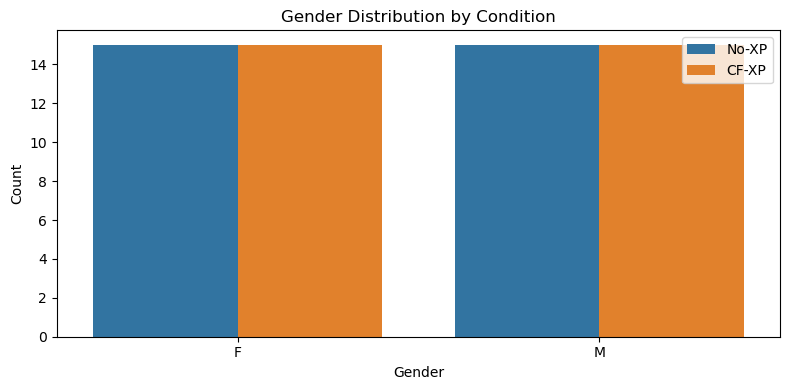


 Plot Trust Values


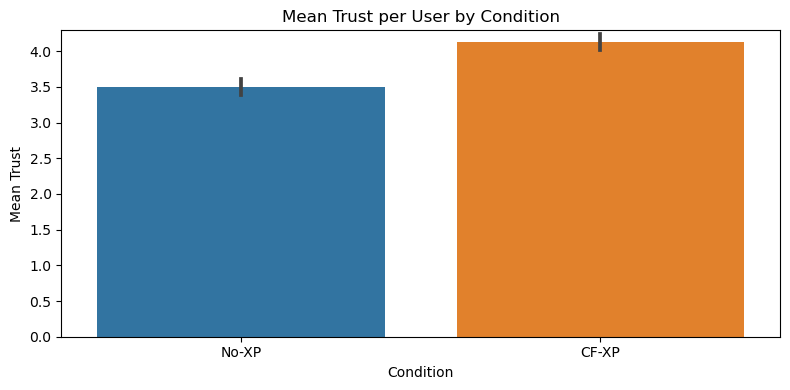

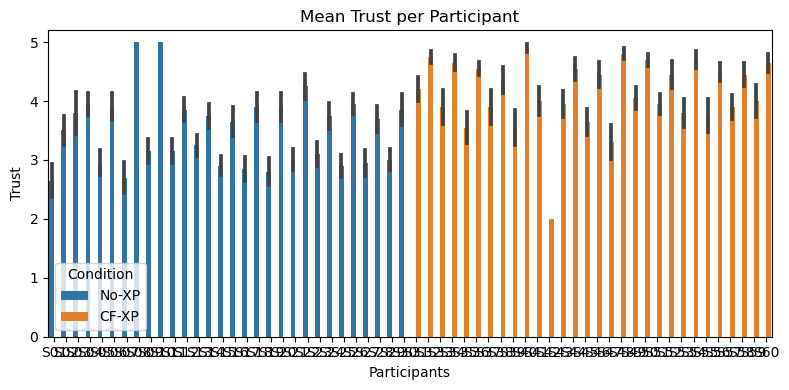


 Plot Reaction Times


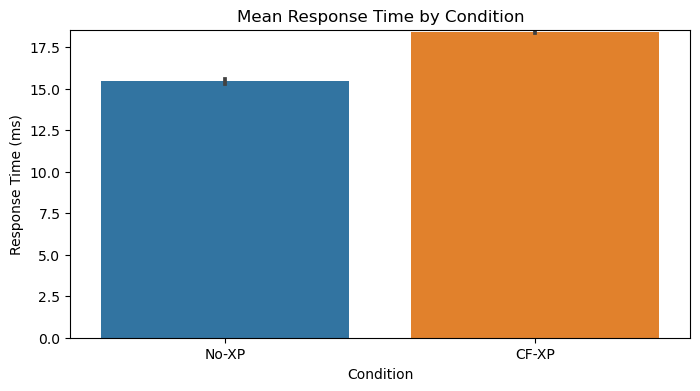

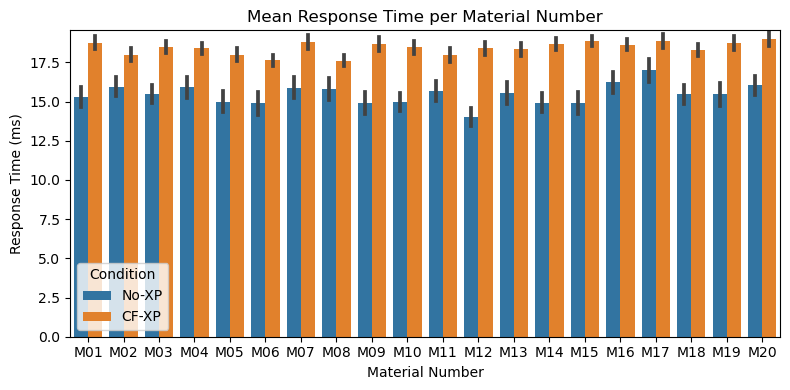

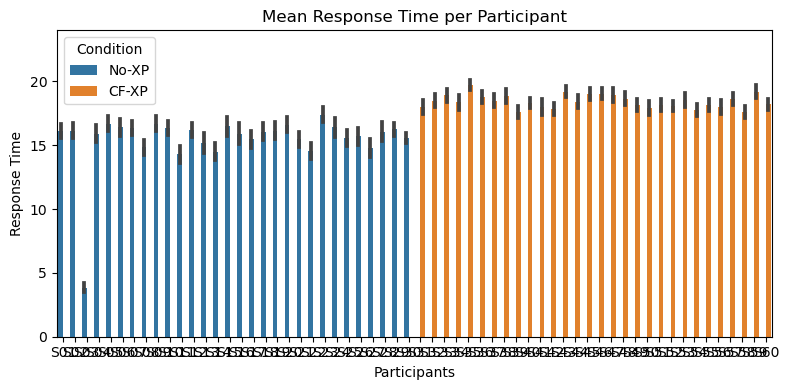

In [5]:
# Look at Data For Individual Participants
unique_participants = trust_data.drop_duplicates(subset='Participant')

# Plot Gender distribution
print('\n Plot Gender distribution')
plt.figure(figsize=(8, 4))
sns.countplot(data=unique_participants, x='Gender', hue='Group', palette=color_palette)
plt.title('Gender Distribution by Condition')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Look at Trust
#plt.figure(figsize=(8, 4))
print('\n Plot Trust Values')
plt.figure(figsize=(8, 4))
# Compute and plot mean trust per group
mean_trust_per_user = trust_data.groupby(['Participant','Group'])['Trust'].mean().reset_index()
sns.barplot(data=mean_trust_per_user, x='Group', y='Trust', palette=color_palette, errorbar='se')
plt.title('Mean Trust per User by Condition')
plt.xlabel('Condition')
plt.ylabel('Mean Trust')
plt.ylim(get_ylim(mean_trust_per_user, 'Group', 'Trust'))
plt.tight_layout()
plt.show()

# A closer look: what about individual participants?
# Plot Trust per Participant
plt.figure(figsize=(8, 4))
sns.barplot(x='Participant', y='Trust', hue='Group', data=trust_data, palette=color_palette, errorbar='se')
plt.title('Mean Trust per Participant')
plt.xlabel('Participants')
plt.ylabel('Trust')
plt.ylim(0,max(trust_data['Trust'])+.2)
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

# Look at Reaction Times
# get ylims
max_ylim_times_mean=get_ylim(reaction_times_task, 'Group', 'ReactionTime')
max_ylim_times=get_material_ylim(reaction_times_task, 'Group', 'Material', 'ReactionTime')
max_ylim_trust=get_material_ylim(trust_data, 'Group', 'Material','Trust',)

plt.figure(figsize=(8, 4))
# Plot Reaction Times per Group
print('\n Plot Reaction Times')
sns.barplot(data=reaction_times_task, x='Group', y='ReactionTime', palette=color_palette, errorbar='se')
plt.title('Mean Response Time by Condition')
plt.xlabel('Condition')
plt.ylabel('Response Time (ms)')
plt.ylim(max_ylim_times_mean)

# Plot Response Time per Material divided by group (to spot Effects Related to Materials)
plt.figure(figsize=(8, 4))
sns.barplot(x='Material', y='ReactionTime', hue='Group', data=reaction_times_task, palette=color_palette, errorbar='se')
plt.title('Mean Response Time per Material Number')
plt.xlabel('Material Number')
plt.ylabel('Response Time (ms)')
plt.ylim(max_ylim_times)
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

# A closer look: what about individual participants?
# Plot Respone time per Participant (to spot Effects Related to Participants)
plt.figure(figsize=(8, 4))
sns.barplot(x='Participant', y='ReactionTime', hue='Group', data=reaction_times_task, palette=color_palette, errorbar='se')
plt.title('Mean Response Time per Participant')
plt.xlabel('Participants')
plt.ylabel('Response Time')
plt.ylim(0,max(reaction_times_task['ReactionTime'])+2)
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

# 4. Data Cleaning
Next, we'll clean the data based on pre-defined criteria.

#### Outliers relative to population mean
Specifically, we want to remove:

- all speedsters  >3 SDs below the mean​
- straight-liners, repeatedly giving same answer​


In [6]:
# Identify speedsters: >3 SDs from population mean
outliers_reaction_times_task = set()
for column in ['ReactionTime']:
    outliers_reaction_times_task.update(identify_outliers(reaction_times_task, column))
    
print("UserIDs of speedsters relative to all participants (task) :" + str(outliers_reaction_times_task))

# Identify straightliners (repeatedly giving the same trust judgements)
print("\nStraightlining behavior:")
# Identify straightliners (repeatedly giving the same trust judgements)
straightliners_task = trust_data.groupby('Participant').filter(lambda x: (x['Trust'].var() == 0))
print("Participants straightlining during task: " + str(straightliners_task['Participant'].unique()))


Measure: ReactionTime
Population mean: 16.947
Population std: 3.317
Admissible range: 7 -- 27
UserIDs of speedsters relative to all participants (task) :{'S03'}

Straightlining behavior:
Participants straightlining during task: ['S08' 'S10' 'S42']


In [7]:
# Combine all population outliers
all_outliers = outliers_reaction_times_task.union(straightliners_task['Participant'].unique())

print("Participants marked as outliers: " + str(all_outliers))
print("N: " + str(len(all_outliers)))

Participants marked as outliers: {'S42', 'S08', 'S03', 'S10'}
N: 4


In [8]:
# Remove population outliers from all datasets
reaction_times_task_cleaned = reaction_times_task[~reaction_times_task['Participant'].isin(all_outliers)]
trust_data_cleaned = trust_data[~trust_data['Participant'].isin(all_outliers)]

#### Wonky Materials?
*Disclaimer: for time reasons, this part is not presented during the AAAI tutorial. For completion and later reference, we present the code here.*

Are there any that are systematically answered unusually quickly?
Here, we want to figure out if there are:

- any materials  >3 SDs from polulation mean
- any materials >3 SDs from person‘s own mean (to catch attention failures of individuals)

In [9]:
# Identify wonky materials: RTs >3 SDs from person‘s own mean
# Define the factor with which std will be multiplied to find the admissible range
removal_factor_user_wise = 3
wonky_trial_user_percentage = 30

# Identify trials (=materials) where users performed more quickly than > 3SD from their own RT mean
reaction_time_outliers = reaction_times_task_cleaned[
    reaction_times_task_cleaned['ReactionTime'] < (
        reaction_times_task_cleaned.groupby('Participant')['ReactionTime'].transform('mean') - 
        removal_factor_user_wise * reaction_times_task_cleaned.groupby('Participant')['ReactionTime'].transform('std')
    )
]

# Display the outliers for Response Time
print("\nParticipants + Material of speedsters relative to own performance (response time):")
print(reaction_time_outliers[['Participant', 'Material', 'ReactionTime']])

## Calculate the percentage of outliers for each Material(=material)
outlier_percentage = reaction_time_outliers['Material'].value_counts(normalize=True) * 100

# Identify Material(=material) where at least 30% of participants were quicker than > 3 SDs of their own performance
wonky_trials = outlier_percentage[outlier_percentage >= wonky_trial_user_percentage].index.tolist()

print("\nList of Material where at least 30% of participants were quicker than > 3 SDs of their own performance:")
print(wonky_trials)

## Show specifics of wonky_trials (=material)
wonky_trials_df = trust_data_cleaned[trust_data_cleaned['Material'].isin(wonky_trials)].groupby('Material').head(1)
print("\nSpecifics of wonky materials:")
print(wonky_trials_df)

# Filter out wonky trials from the dataframes - CAREFUL! LIKELY BREAKS BALANCE OF TRIALS!
def remove_wonky_trials(df, wonky_trials):
    return df[~df['Material'].isin(wonky_trials)]
# Remove wonky trials from all relevant dataframes
reaction_times_task_cleaned = remove_wonky_trials(reaction_times_task_cleaned, wonky_trials)
trust_data_cleaned = remove_wonky_trials(trust_data_cleaned, wonky_trials)


Participants + Material of speedsters relative to own performance (response time):
Empty DataFrame
Columns: [Participant, Material, ReactionTime]
Index: []

List of Material where at least 30% of participants were quicker than > 3 SDs of their own performance:
[]

Specifics of wonky materials:
Empty DataFrame
Columns: [Participant, Group, Material, Gender, Trust]
Index: []


# 5. Eyeballing After Cleaning


 Plot Gender distribution


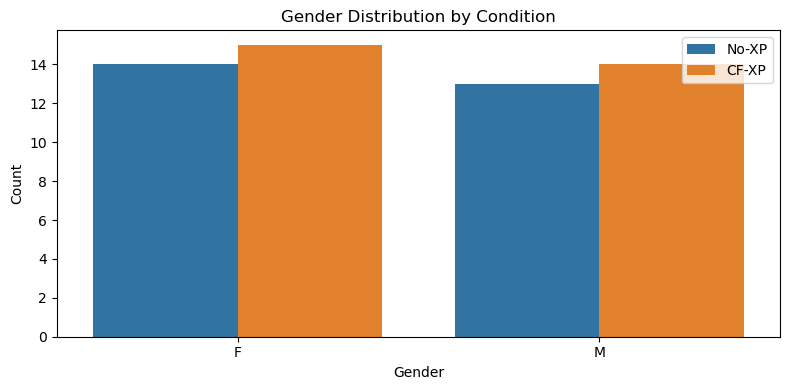


 Plot Trust Values


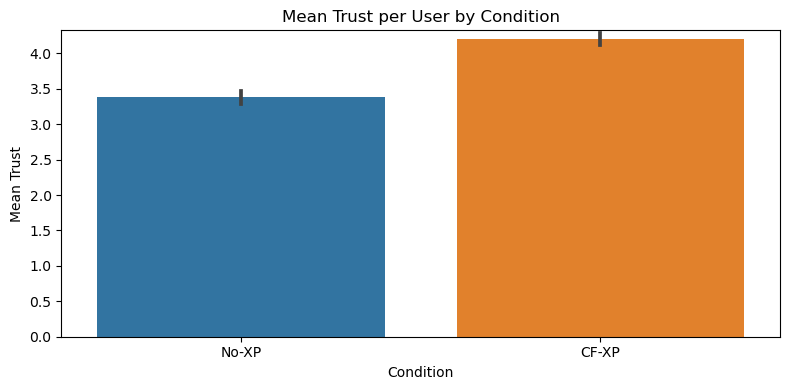

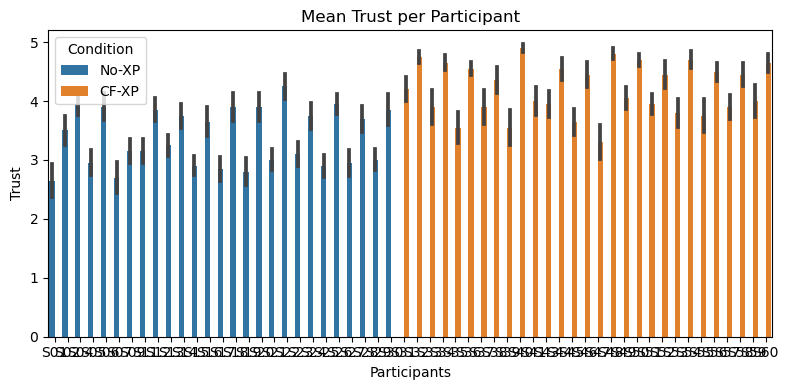


 Plot Reaction Times


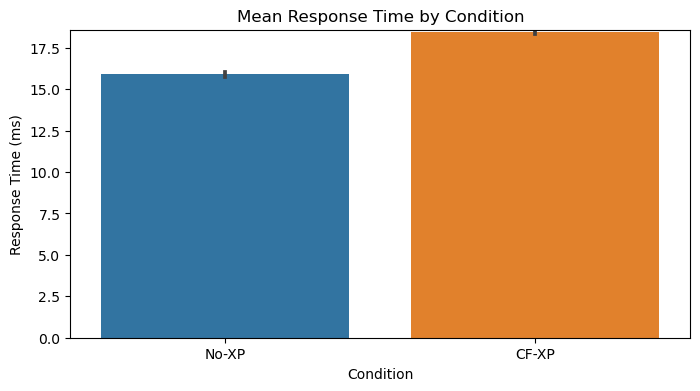

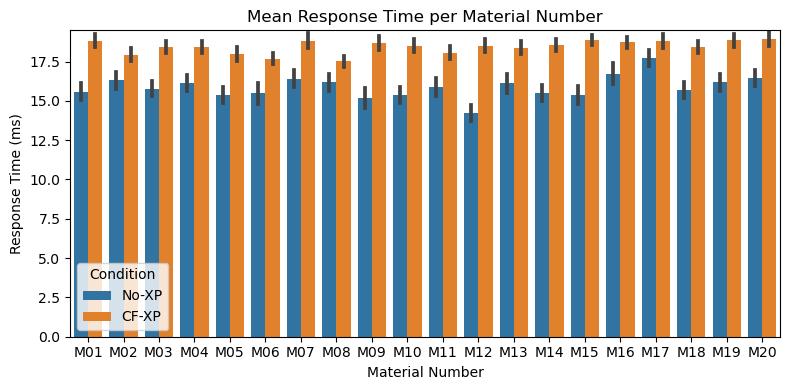

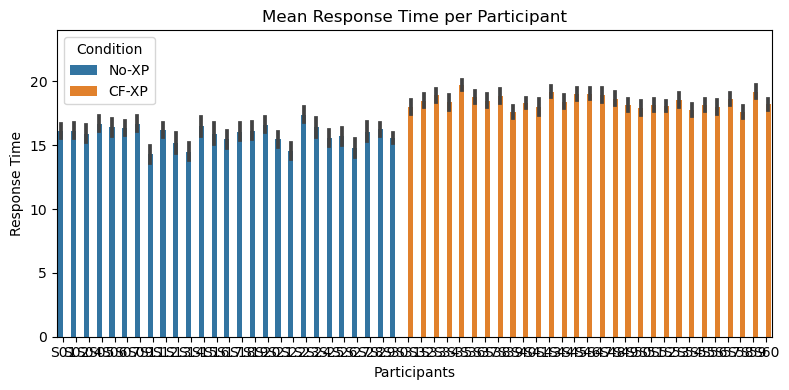

In [10]:
# Look at Data For Individual Participants
unique_participants_cleaned = trust_data_cleaned.drop_duplicates(subset='Participant')

# Plot Gender distribution
print('\n Plot Gender distribution')
plt.figure(figsize=(8, 4))
sns.countplot(data=unique_participants_cleaned, x='Gender', hue='Group', palette=color_palette)
plt.title('Gender Distribution by Condition')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Look at Trust
print('\n Plot Trust Values')
plt.figure(figsize=(8, 4))
# Compute and plot mean trust per group
mean_trust_per_user = trust_data_cleaned.groupby(['Participant','Group'])['Trust'].mean().reset_index()
sns.barplot(data=mean_trust_per_user, x='Group', y='Trust', palette=color_palette, errorbar='se')
plt.title('Mean Trust per User by Condition')
plt.xlabel('Condition')
plt.ylabel('Mean Trust')
plt.ylim(get_ylim(mean_trust_per_user, 'Group', 'Trust'))
plt.tight_layout()
plt.show()

# A closer look: what about individual participants?
# Plot Trust per Participant
plt.figure(figsize=(8, 4))
sns.barplot(x='Participant', y='Trust', hue='Group', data=trust_data_cleaned, palette=color_palette, errorbar='se')
plt.title('Mean Trust per Participant')
plt.xlabel('Participants')
plt.ylabel('Trust')
plt.ylim(0,max(trust_data_cleaned['Trust'])+.2)
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

# Look at Reaction Times
# get ylims
max_ylim_times_mean=get_ylim(reaction_times_task_cleaned, 'Group', 'ReactionTime')
max_ylim_times=get_material_ylim(reaction_times_task_cleaned, 'Group', 'Material', 'ReactionTime')
max_ylim_trust=get_material_ylim(trust_data_cleaned, 'Group', 'Material','Trust',)

plt.figure(figsize=(8, 4))
# Plot Reaction Times per Group
print('\n Plot Reaction Times')
sns.barplot(data=reaction_times_task_cleaned, x='Group', y='ReactionTime', palette=color_palette, errorbar='se')
plt.title('Mean Response Time by Condition')
plt.xlabel('Condition')
plt.ylabel('Response Time (ms)')
plt.ylim(max_ylim_times_mean)

# Plot Response Time per Material divided by group (to spot Effects Related to Materials)
plt.figure(figsize=(8, 4))
sns.barplot(x='Material', y='ReactionTime', hue='Group', data=reaction_times_task_cleaned, palette=color_palette, errorbar='se')
plt.title('Mean Response Time per Material Number')
plt.xlabel('Material Number')
plt.ylabel('Response Time (ms)')
plt.ylim(max_ylim_times)
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

# A closer look: what about individual participants?
# Plot Respone time per Participant (to spot Effects Related to Participants)
plt.figure(figsize=(8, 4))
sns.barplot(x='Participant', y='ReactionTime', hue='Group', data=reaction_times_task_cleaned, palette=color_palette, errorbar='se')
plt.title('Mean Response Time per Participant')
plt.xlabel('Participants')
plt.ylabel('Response Time')
plt.ylim(0,max(reaction_times_task_cleaned['ReactionTime'])+2)
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

# 6. Descriptive Statistics
We'll compute descriptive statistics for the demographics and check if groups are significantly different in terms of age and gender.

## Average Time Needed

In [11]:
sums_per_participant = reaction_times_task_cleaned.groupby('Participant')['ReactionTime'].sum()
mean_total_time = sums_per_participant.mean()
sd_total_time = sums_per_participant.std()
print(mean_total_time)
print('Mean +/- SD total time needed per participant:')
print(str(round(mean_total_time/60,2)) + ' minutes +/- '+str(round(sd_total_time/60,2)))

344.25
Mean +/- SD total time needed per participant:
5.74 minutes +/- 0.48


## Visualize Demographics (before and after cleaning)


Summary of the number of participants in each group:
   Group Gender  Number of Participants
0  CF-XP      F                      15
1  CF-XP      M                      14
2  No-XP      F                      14
3  No-XP      M                      13

 Plot Gender distribution


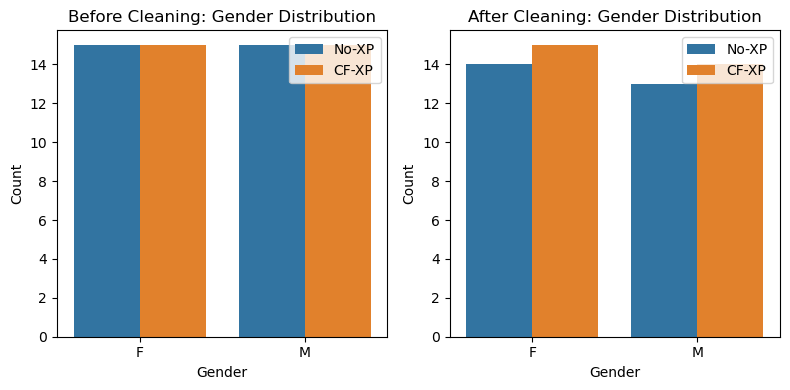

In [12]:
# Provide a summary of the number of participants in each group
participant_summary = unique_participants_cleaned.groupby(['Group','Gender']).size().reset_index(name='Number of Participants')

print("\nSummary of the number of participants in each group:")
print(participant_summary)

# Plot: After data cleaning
plt.figure(figsize=(8, 4))

# Plot Gender Distibution again, as a reminder:
print('\n Plot Gender distribution')
plt.subplot(1, 2, 1)
sns.countplot(data=unique_participants, x='Gender', hue='Group', palette=color_palette)
plt.title('Before Cleaning: Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
sns.countplot(data=unique_participants_cleaned, x='Gender', hue='Group', palette=color_palette)
plt.title('After Cleaning: Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Test For Gender Differences

In [13]:
from scipy.stats import chi2_contingency, chi2, norm, shapiro, levene, kruskal

# Chi-Square Test of Independence for Gender Distributions
contingency_table = pd.crosstab(trust_data_cleaned['Group'], trust_data_cleaned['Gender'])
chi2_test_result = chi2_contingency(contingency_table)

print("Chi^2 Test of Independence for Gender Distributions:")
print(f"Chi^2 Statistic: {round(chi2_test_result[0],3)}, p-value: {round(chi2_test_result[1],3)}")
# if p > 0.05, H0 holds: we can assume that there is no dependence between Gender and Group

Chi^2 Test of Independence for Gender Distributions:
Chi^2 Statistic: 0.0, p-value: 1.0


**Conclusion:** As p > 0.05 in the Chi^2 test, we can assume that there is no dependence between the gender and groups. Thus, we don't need to account for gender further as a covariate.

# 7. Statistical Analysis (finally!)
We'll analyze potential group differences in terms of
* reported trust in the system and
* response time

## First: Trust

We will kick-off with the trust judgements between groups first.

### Step 1: Plot again to refresh our memory


 Plot Trust Values


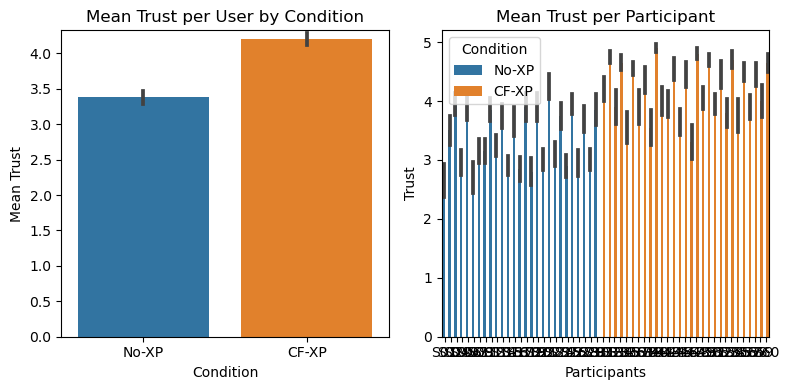

In [14]:
## Look at Trust
#plt.figure(figsize=(8, 4))
print('\n Plot Trust Values')
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
# Compute and plot mean trust per group
mean_trust_per_user = trust_data_cleaned.groupby(['Participant','Group'])['Trust'].mean().reset_index()
sns.barplot(data=mean_trust_per_user, x='Group', y='Trust', palette=color_palette, errorbar='se')
plt.title('Mean Trust per User by Condition')
plt.xlabel('Condition')
plt.ylabel('Mean Trust')
plt.ylim(get_ylim(mean_trust_per_user, 'Group', 'Trust'))

# A closer look: what about individual participants?
# Plot Trust per Participant
#plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 2)
sns.barplot(x='Participant', y='Trust', hue='Group', data=trust_data_cleaned, palette=color_palette, errorbar='se')
plt.title('Mean Trust per Participant')
plt.xlabel('Participants')
plt.ylabel('Trust')
plt.ylim(0,max(trust_data_cleaned['Trust'])+.2)
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

### Step 2: Simple two-group case - what test to use?

Given that responses were on a Likert-scale ("strongly disagree - strongly agree"), the rule of thumb is to use the non-parametric Mann Whitney U Test. As a non-parametric test, it has the advantage that is has fewer assumptions. E.g., the difference in group size after removal of dodgy data is not a problem.
(Refer to basic statistics books / classes when deciding which tests to use when and why).    

In [15]:
from scipy.stats import mannwhitneyu

# Aggregate the Trust Measure per Participant
participant_trust = trust_data_cleaned.groupby(['Participant', 'Group'])['Trust'].mean().reset_index()
participant_trust_mean = participant_trust.groupby(['Group'])['Trust'].mean().reset_index()
participant_trust_sd = participant_trust.groupby(['Group'])['Trust'].std().reset_index()

print("\nAggregated Trust Data")
print("Means:")
print(participant_trust_mean)
print("Std:")
print(participant_trust_sd)

# Separate Trust Scores for Groups
trust_no_xp = participant_trust.loc[participant_trust['Group'] == 'No-XP', 'Trust']
trust_cf_xp = participant_trust.loc[participant_trust['Group'] == 'CF-XP', 'Trust']

# Perform the Mann-Whitney U test
stat, p_val = mannwhitneyu(trust_no_xp, trust_cf_xp, alternative='two-sided')

print(f"\nMann-Whitney U statistic: {stat:.3f}, p-value: {p_val:.10f}")


Aggregated Trust Data
Means:
   Group     Trust
0  CF-XP  4.203448
1  No-XP  3.379630
Std:
   Group     Trust
0  CF-XP  0.439954
1  No-XP  0.482633

Mann-Whitney U statistic: 87.000, p-value: 0.0000006030


**Conclusion:**
Sucess! We can now report that reported trust between groups did indeed differ, with the Counterfactual group reporting significanly higher trust values.

## Second: Response Time

We will continue the response times differences between groups.

### Step 1: Plot again to refresh our memory


 Plot Reaction Times


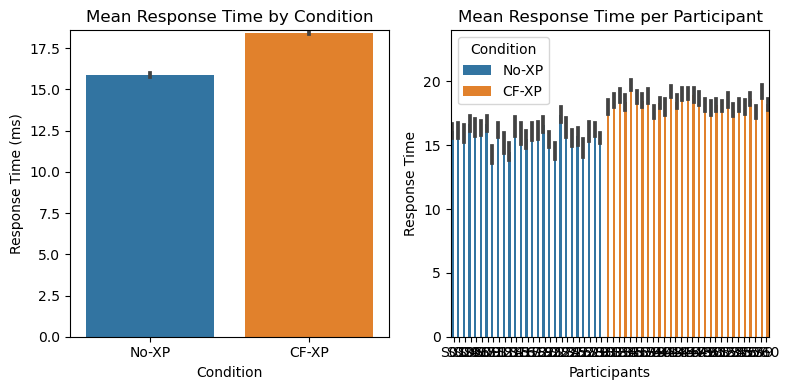

In [16]:
# Plot Reaction Times per Group
print('\n Plot Reaction Times')
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.barplot(data=reaction_times_task_cleaned, x='Group', y='ReactionTime', palette=color_palette, errorbar='se')
plt.title('Mean Response Time by Condition')
plt.xlabel('Condition')
plt.ylabel('Response Time (ms)')
plt.ylim(max_ylim_times_mean)

# A closer look: what about individual participants?
# Plot Respone time per Participant (to spot Effects Related to Participants)
plt.subplot(1, 2, 2)
sns.barplot(x='Participant', y='ReactionTime', hue='Group', data=reaction_times_task_cleaned, palette=color_palette, errorbar='se')
plt.title('Mean Response Time per Participant')
plt.xlabel('Participants')
plt.ylabel('Response Time')
plt.ylim(0,max(reaction_times_task_cleaned['ReactionTime'])+2)
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

### Step 2: Simple two-group case - what test to use?

Given that response times are continuous data (in seconds), we could use an independent samples t-test.
(Refer to basic statistics books / classes when deciding which tests to use when and why). 

Note that this kind of test has some assumptions that need to be checked before we can actually do it:

1. Independence:
    * Design-Based: Ensure that your data collection process guarantees that the observations (or aggregated scores per participant) are independent. This is usually determined by your study design.
    ***Our design ensures this.**

2. Normality:
    * What to Check: The dependent variable (e.g., aggregated reaction time or trust score per participant) should be approximately normally distributed in each group.
    * How to Test:
        * Shapiro–Wilk Test: Provides a statistical test for normality.
        * Q–Q Plots or Histograms: Visual inspection can help detect deviations from normality.

3. Homogeneity of Variances (Equal Variances):
    * What to Check: The variances in the two groups should be roughly equal.
    * How to Test:
        * Levene’s Test: Tests for equality of variances.
        * Bartlett’s Test: Another option, but it is more sensitive to departures from normality.

In [17]:
from scipy import stats

# Aggregated Data Participant
participant_rt = reaction_times_task_cleaned.groupby(['Participant', 'Group'])['ReactionTime'].mean().reset_index()
participant_rt_mean = participant_rt.groupby(['Group'])['ReactionTime'].mean().reset_index()
participant_rt_sd = participant_rt.groupby(['Group'])['ReactionTime'].std().reset_index()

print("\nAggregated Response Time Data")
print("Means:")
print(participant_rt_mean)
print("Std:")
print(participant_rt_sd)

# Separate Reaction Times by Group
rt_no_xp = participant_rt.loc[participant_rt['Group'] == 'No-XP', 'ReactionTime']
rt_cf_xp = participant_rt.loc[participant_rt['Group'] == 'CF-XP', 'ReactionTime']

### 1. Normality Tests
print("\nPerform Shapiro-Wilk Tests to Check Normality")
print("\nInterpretation: p > 0.05 indicates that the data do not significantly deviate from a normal distribution.")
# Shapiro-Wilk Test for No-XP group
shapiro_no_xp = stats.shapiro(rt_no_xp)
print(f"Shapiro-Wilk (No-XP): W={shapiro_no_xp.statistic:.3f}, p={shapiro_no_xp.pvalue:.3f}")

# Shapiro-Wilk Test for CF-XP group
shapiro_cf_xp = stats.shapiro(rt_cf_xp)
print(f"Shapiro-Wilk (CF-XP): W={shapiro_cf_xp.statistic:.3f}, p={shapiro_cf_xp.pvalue:.3f}")

### 2. Homogeneity of Variances

# Levene's Test for equal variances
print("\nPerform Levene's Test to Check for Equal Variances")
print("\nInterpretation: p > 0.05 indicates that the group variances can be assumed equal.")
levene_test = stats.levene(rt_no_xp, rt_cf_xp)
print(f"Levene's Test: W={levene_test.statistic:.3f}, p={levene_test.pvalue:.3f}")


Aggregated Response Time Data
Means:
   Group  ReactionTime
0  CF-XP     18.448276
1  No-XP     15.885185
Std:
   Group  ReactionTime
0  CF-XP      0.517632
1  No-XP      0.738998

Perform Shapiro-Wilk Tests to Check Normality

Interpretation: p > 0.05 indicates that the data do not significantly deviate from a normal distribution.
Shapiro-Wilk (No-XP): W=0.952, p=0.235
Shapiro-Wilk (CF-XP): W=0.975, p=0.700

Perform Levene's Test to Check for Equal Variances

Interpretation: p > 0.05 indicates that the group variances can be assumed equal.
Levene's Test: W=1.469, p=0.231


**Conclusion:** For our response time data, independence, normality and homogeneity of variances is given, so we can proceed with the t-test.

In [18]:
# Perform the independent samples t-test
t_stat, p_val = stats.ttest_ind(rt_no_xp, rt_cf_xp, equal_var=True)  # Use equal_var=False for Welch's t-test if variances differ

t_df = len(rt_no_xp) + len(rt_cf_xp) - 2

print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.25f}")
print(f"Degrees of freedom: ",t_df) 

t-statistic: -15.118, p-value: 0.0000000000000000000047043
Degrees of freedom:  54


**Conclusion:**
Sucess! We can now report that responses times between groups did indeed differ, with the Counterfactual group taking significanly longer.

# 8. How to Report Results in a Paper?

This is an example excerpt how these insights could look like in a paper:

## Results

From the 60 participants we recruited, data from one participant was excluded as their reaction time was more than 3 SDs lower than the sample mean.
Three additional participants were excluded, given that their response patterns were uniform across all 20 items, suggesting a lack of engagement or indiscriminate responding that compromised the validity of their data.
Thus, the final analysis includes data from 56 participants randomly assigned to the two groups, with 29 participants in group CF-XP (14 male / 15 female), and 27 in group No-XP (13 male / 14 female). 
There were not statistically reliable differences in terms of gender distribution between groups.
On average, participants needed 5.74 minutes (*SD*=0.48) to complete the study.

In terms of reported trust, participants in the CF-XP group (*M*=4.20, *SD*=0.43), compared to participants in the No-XP group (*M*=3.38, *SD*=0.48), showed significantly higher trust scores (*U*= 87.00, *p* < .000).
Group differences were also statistically significant for response time data (*t*(54) = 15.12, *p* < .000) with participants in the CF-XP group (*M*=18.45, *SD*=0.52) taking significantly longer than participants in the No-XP group (*M*=15.89, *SD*=0.74).